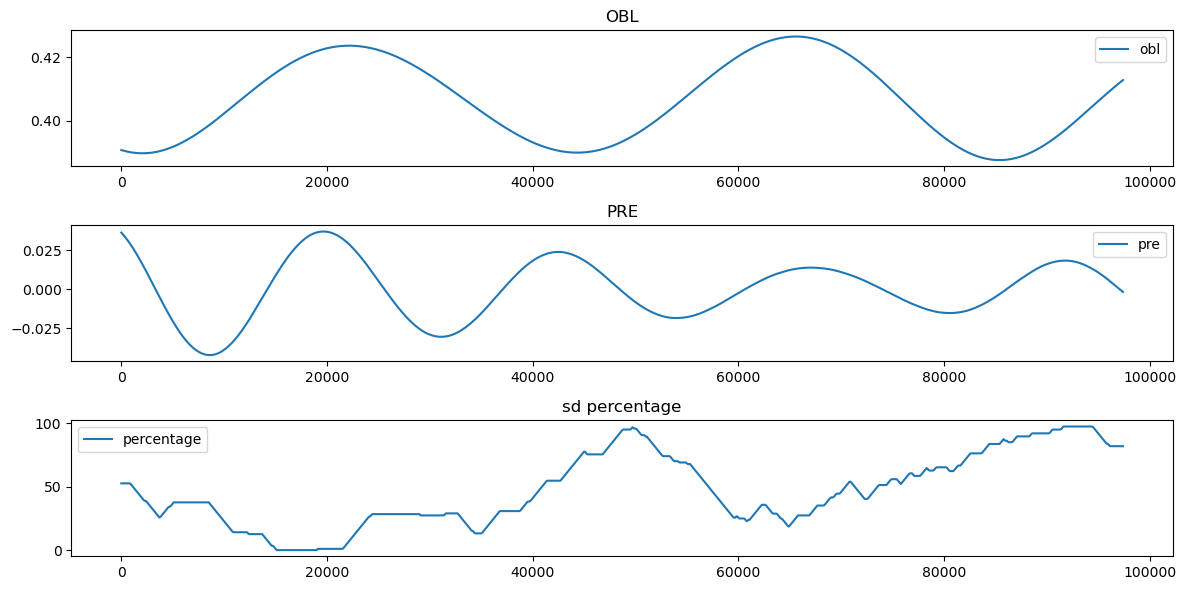

obl: 975


In [1]:
# read csv data
import pandas as pd
df_obl = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\inso_data\obl_long.csv")
df_pre = pd.read_csv(r"D:\VScode\bipolar_seesaw_CCM\inso_data\pre_long.csv")
df_sd = pd.read_csv("output/df_stadial_duration_SlidingWindow.csv")

# plot data using 3 by 1 subplots
import matplotlib.pyplot as plt
import numpy as np
# Create 3 x 1 subplots
fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=False)

# Plot df_obl
ax[0].plot(df_obl.iloc[:, 0], df_obl.iloc[:, 1], label=df_obl.columns[1])
ax[0].set_title("OBL")
ax[0].legend()

# Plot df_pre
ax[1].plot(df_pre.iloc[:, 0], df_pre.iloc[:, 1], label=df_pre.columns[1])
ax[1].set_title("PRE")
ax[1].legend()

# Plot df_sd
ax[2].plot(df_sd.iloc[:, 0], df_sd.iloc[:, 1], label=df_sd.columns[1])
ax[2].set_title("sd percentage")
ax[2].legend()

plt.tight_layout()
plt.show()

# Print the length of df_obl
print("obl:", len(df_obl))

In [25]:
from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)



best_E, best_tau, rho_matrix = cf.find_optimal_E_tau(
    df_sd   = df_sd,
    df_pre  = df_pre,
    maxE    = 5,
    maxTau  = 20
)
print("Optimal E =", best_E, "  Optimal tau =", best_tau)


[INFO] Using lib=1 965, pred=1 965


[INFO] Best E=3, tau=16 with rho=0.980
Optimal E = 3   Optimal tau = 16


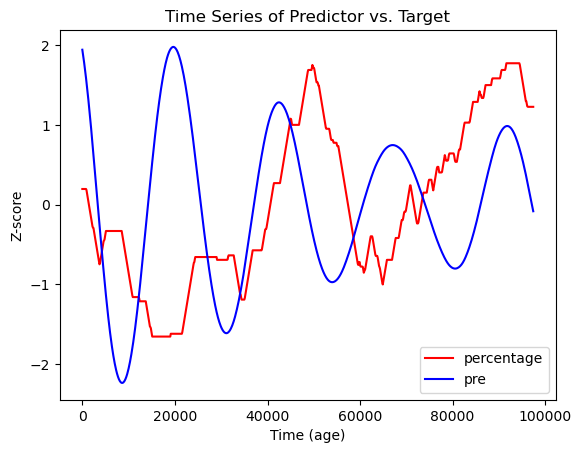

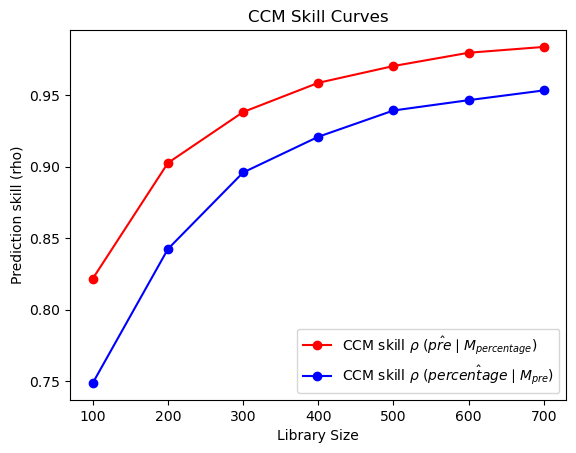

In [ ]:
from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)


result = cf.ccm_DOXmapForcing(
    df_sd      = df_sd,
    df_pre     = df_pre,
    E          = 4,
    tau        = 8,
    libSizes   = "100 200 300 400 500 600 700",
    Tp=0,
    sample     = 20,
    showPlot   = True
)



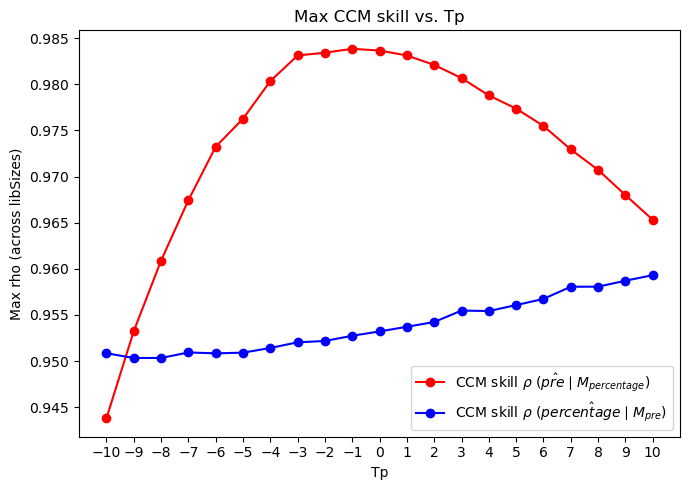

In [ ]:
from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)


Tps_list, forward_rhos, reverse_rhos = cf.find_optimal_Tp(
    df_sd      = df_sd,
    df_pre     = df_pre,
    E          = 4,
    tau        = 8,
    libSizes   = "100 200 300 400 500 600 700",
    sample     = 20,
    Tps        = range(-10, 11),
    interactive=False   
)

In [ ]:
from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)


Tps_list, forward_rhos, reverse_rhos = cf.find_optimal_Tp(
    df_sd      = df_sd,
    df_pre     = df_pre,
    E          = 4,
    tau        = 8,
    libSizes   = "100 200 300 400 500 600 700",
    sample     = 20,
    Tps        = range(-10, 11),
    interactive=True   
)

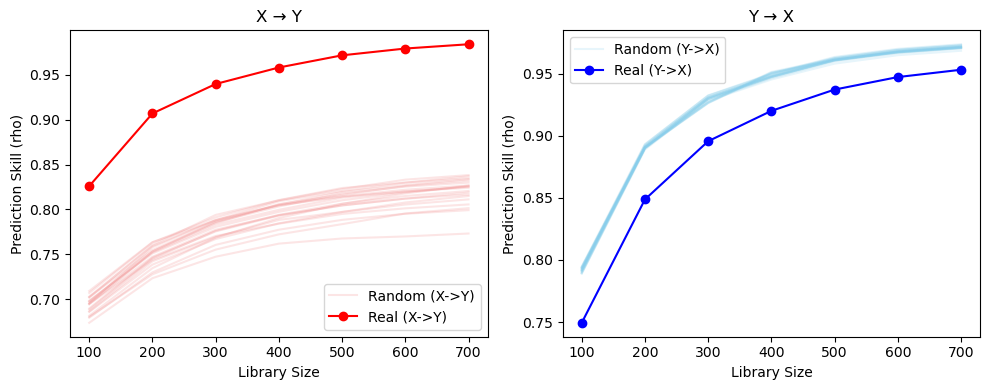

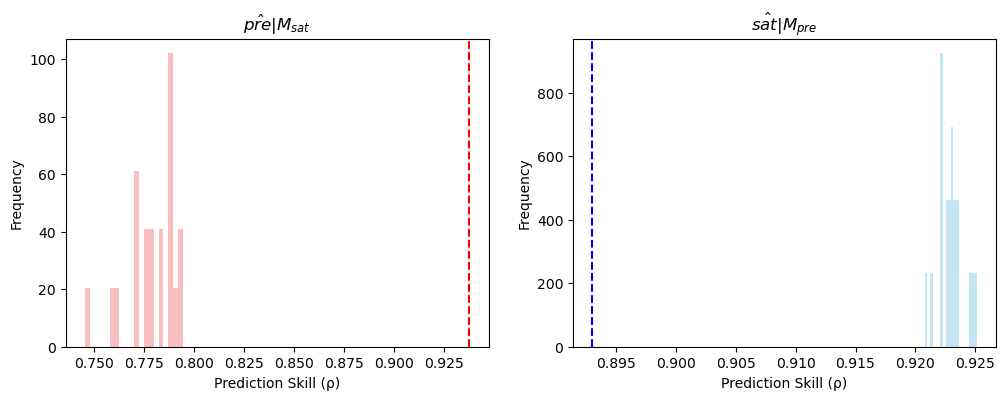

True


In [4]:
from toolbox import significant_test as st
import importlib
importlib.reload(st)

ccm_out, ran_ccm_list = st.ccm_significance_statistic(
    df_sd      = df_sd,
    df_pre     = df_pre,
    E         = 4,
    tau       = 8,
    fraction  = 0.1,
    n_ran     = 20,
    libSizes  = "100 200 300 400 500 600 700",
    sample    = 100,
    showPlot  = True
)

test_result = st.ccm_significance_test(ccm_out, ran_ccm_list, if_plot=True)
print(test_result)




# from toolbox import significant_test as st
# import importlib
# importlib.reload(st)

# ccm_out, ran_ccm_list,test_result = st.ccm_significance_test(
#     df_sd      = df_sd,
#     df_pre     = df_pre,
#     E         = 4,
#     tau       = 8,
#     Tp =0,
#     n_ran     = 20,
#     libSizes  = "100 200 300 400 500 600 700",
#     sample    = 100,
#     showPlot  = True
# )


# print(test_result)

# Testing Obl

In [34]:
from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)



best_E, best_tau, rho_matrix = cf.find_optimal_E_tau(
    df_sd   = df_sd,
    df_pre  = df_obl,
    maxE    = 5,
    maxTau  = 20
)
print("Optimal E =", best_E, "  Optimal tau =", best_tau)

[INFO] Using lib=1 965, pred=1 965


[INFO] Best E=4, tau=11 with rho=0.967
Optimal E = 4   Optimal tau = 11


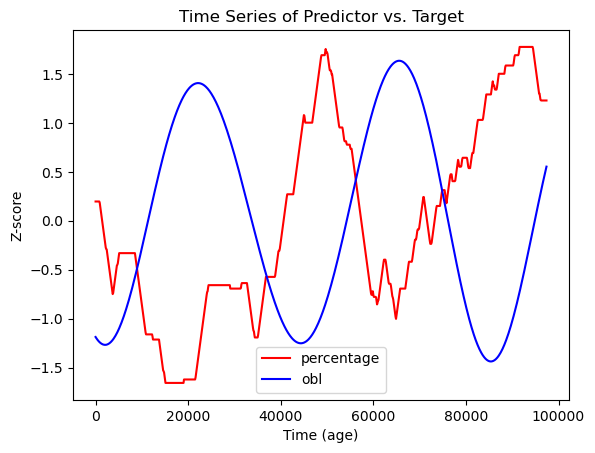

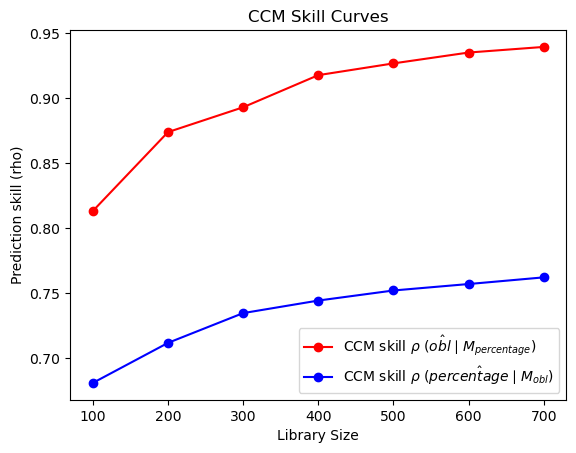

In [36]:
from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)


result = cf.ccm_DOXmapForcing(
    df_sd      = df_sd,
    df_pre     = df_obl,
    E          = 4,
    tau        = 11,
    libSizes   = "100 200 300 400 500 600 700",
    sample     = 20,
    showPlot   = True
)


In [59]:
from toolbox import ccm_functions as cf
import importlib
importlib.reload(cf)


Tps_list, forward_rhos, reverse_rhos = cf.find_optimal_Tp(
    df_sd      = df_sd,
    df_pre     = df_obl,
    E          = 4,
    tau        = 8,
    libSizes   = "100 200 300 400 500 600 700",
    sample     = 20,
    Tps        = range(-10, 11),
    interactive=True   
)

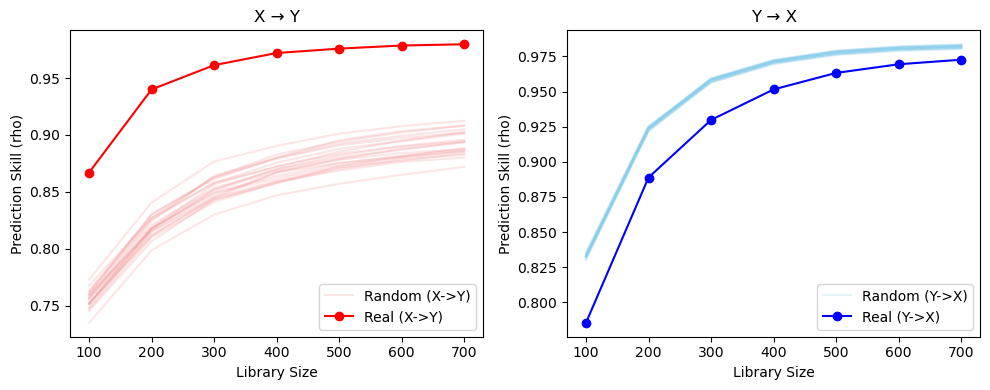

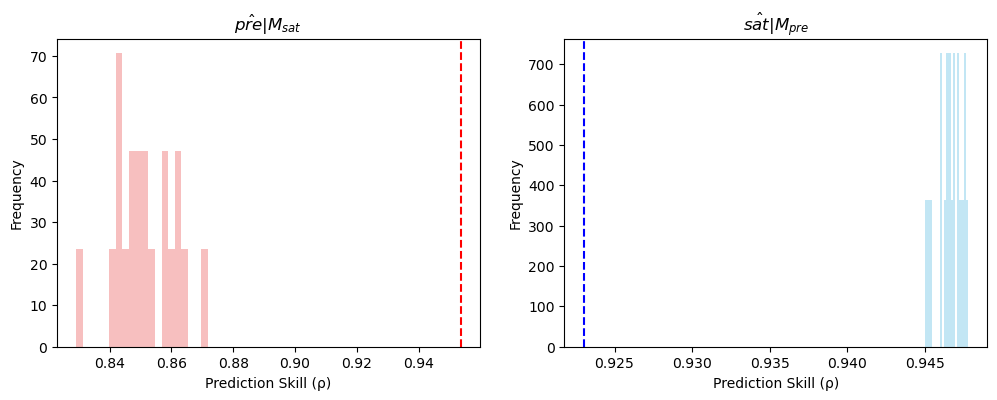

True


In [5]:
from toolbox import significant_test as st
import importlib
importlib.reload(st)

ccm_out, ran_ccm_list = st.ccm_significance_statistic(
    df_sd      = df_sd,
    df_pre     = df_pre,
    E         = 4,
    tau       = 11,
    fraction  = 0.1,
    n_ran     = 20,
    libSizes  = "100 200 300 400 500 600 700",
    sample    = 100,
    showPlot  = True
)

test_result = st.ccm_significance_test(ccm_out, ran_ccm_list, if_plot=True)
print(test_result)


# from toolbox import significant_test as st
# import importlib
# importlib.reload(st)

# ccm_out, ran_ccm_list,test_result = st.ccm_significance_test(
#     df_sd      = df_sd,
#     df_pre     = df_obl,
#     E         = 4,
#     tau       = 11,
#     Tp =0,
#     n_ran     = 20,
#     libSizes  = "100 200 300 400 500 600 700",
#     sample    = 100,
#     showPlot  = True
# )


# print(test_result)

In [18]:
import xarray as xr
import pandas as pd
import numpy as np
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyEDM import EmbedDimension

# Step 1: Automatically figure out the column names (other than "age")
column_name = df_sd.columns[1]    # second column in df_sd
target_name = df_pre.columns[1]   # second column in df_pre

# Step 2: Create df_tmp automatically
df_tmp = pd.DataFrame({
    "Time":       df_pre["age"],         # or df_sd["age"], if same length
    column_name:  df_sd[column_name],    # predictor
    target_name:  df_pre[target_name],   # target
})

# left lib and pred be the length of the data-10
lib_length = len(df_tmp) - 10
lib_str = f"1 {lib_length}"
pred_str = f"1 {lib_length}"
print(f"lib_str: {lib_str}, pred_str: {pred_str}")


RhoMatrix = np.zeros((5, 20))

# For each tau in 1..20, call EmbedDimension once with maxE=5 and Tp=0
for tau in range(1, 21):
    edm_out = EmbedDimension(
        dataFrame = df_tmp,
        columns   = column_name,  # predictor
        target    = target_name,  # target to predict
        maxE      = 5,            # We'll evaluate E=1..5
        tau       = tau,
        Tp        = 0,
        lib       = lib_str,      # adapt ranges if needed
        pred      = pred_str,
        showPlot  = False
    )

    # edm_out is a DataFrame with columns like [E, rho, MAE, RMSE, ...]
    # We'll collect the rho for each E=1..5 into RhoMatrix
    for e_row in edm_out.itertuples():
        # Make sure e_val is an integer
        e_val = int(e_row.E)  # e might come back as float 1.0, 2.0, etc.
        rho_val = e_row.rho
        # Use integer indices for array indexing
        RhoMatrix[e_val - 1, tau - 1] = rho_val

# Axis values for plotting
E_axis   = np.arange(1, 6)   # E = 1..5
Tau_axis = np.arange(1, 21)  # tau = 1..20

# Make an interactive 3D surface plot
fig = go.Figure(data=[go.Surface(z=RhoMatrix, x=Tau_axis, y=E_axis)])
fig.update_layout(
    title='Interactive 3D Surface: Rho vs. E and tau',
    scene=dict(
        xaxis_title='tau',
        yaxis_title='E',
        zaxis_title='rho',
    ),
    autosize=True,
)
fig.show()



lib_str: 1 965, pred_str: 1 965


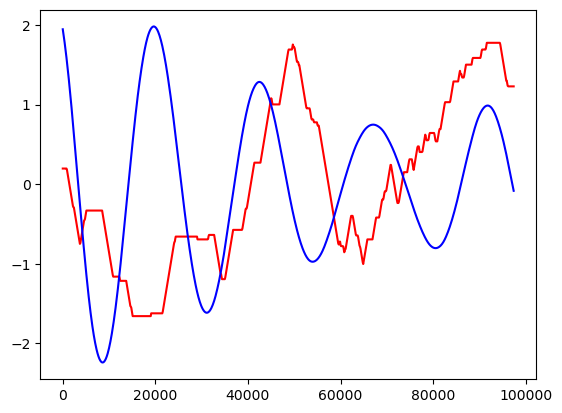

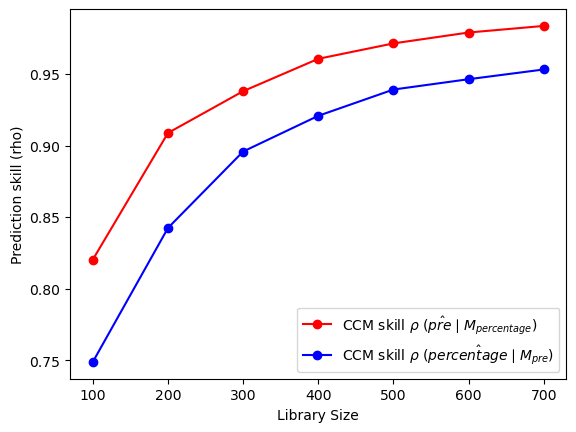

In [11]:

import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt
from scipy.stats import zscore


ages = df_pre["age"]

column_name=df_sd.columns[1]
target_name=df_pre.columns[1]

df = pd.DataFrame({
    "Time": ages,
    column_name: df_sd['percentage'],
    target_name:  df_pre["pre"]         # target to predict
})


# plot df
fig, ax = plt.subplots()
plt.plot(df['Time'], zscore(df[column_name]), 'r-')
plt.plot(df['Time'], zscore(df[target_name]), 'b-')



# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 4,
    tau         = 8,
    columns     = column_name,   # predictor
    target      = target_name,   # target
    libSizes    = "100 200 300 400 500 600 700",
    sample      = 20,
    random      = True,
    replacement = False,
    Tp          = 0
)

fig, ax = plt.subplots()

# Construct the correct keys for the DataFrame columns
forward_key = f"{column_name}:{target_name}"
reverse_key = f"{target_name}:{column_name}"

plt.plot(ccm_out["LibSize"],
         ccm_out[forward_key],
         'ro-',
         label=fr"CCM skill $\rho$ ($\hat{{{target_name}}}\mid M_{{{column_name}}}$)")

plt.plot(ccm_out["LibSize"],
         ccm_out[reverse_key],
         'bo-',
         label=fr"CCM skill $\rho$ ($\hat{{{column_name}}}\mid M_{{{target_name}}}$)")

plt.xlabel("Library Size")
plt.ylabel("Prediction skill (rho)")
plt.legend()
plt.show()

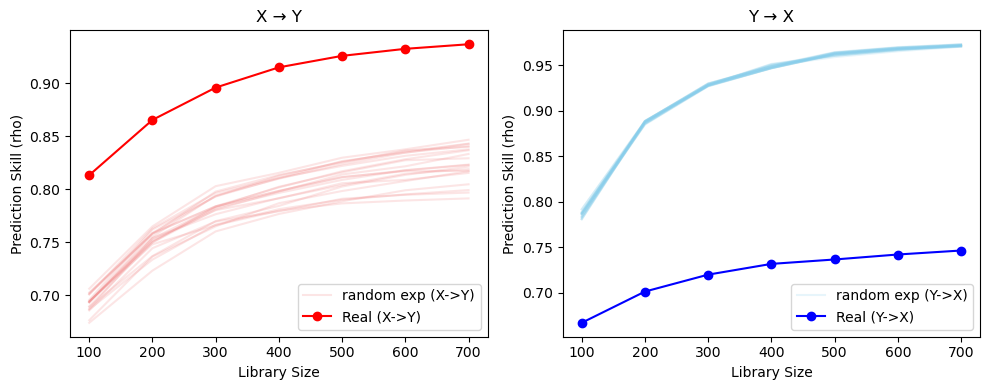

In [ ]:
def randomize_stadial(stadial_data, fraction=0.1, seed=None):
    """
    1) Multiply original data by (1 + random variation in [-fraction, fraction]).
    2) Chop in half and rejoin (destroys original time ordering).
    """
    if seed is not None:
        np.random.seed(seed)
    
    N = len(stadial_data)
    # 1. Vary by ± fraction
    variation = 1.0 + fraction * (2*np.random.rand(N) - 1.0)  # e.g., ±10%
    randomized = stadial_data * variation
    
    # 2. Chop and rejoin
    half = N // 2
    randomized_swapped = np.concatenate([randomized[half:], randomized[:half]])
    
    return randomized_swapped


df = pd.DataFrame({
    "Time": ages,
    "X": df_sd['percentage'],
    "Y":  df_pre["pre"]         # target to predict
})

ccm_out = CCM(
    dataFrame   = df,
    E           = 4,
    tau         = 10,
    columns     = "X",   # predictor
    target      = "Y",   # target
    libSizes    = "100 200 300 400 500 600 700",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 0
)


# Number of surrogate draws
n_ran = 20

# Storage for surrogates
ran_ccm_list_xy = []  # for X->Y direction


lib_sizes = "100 200 300 400 500 600 700"

for i in range(n_ran):
    # 1) Generate random surrogate stadial data
    X_ran = randomize_stadial(df['X'].values, fraction=0.1)
    
    # 2) Create DataFrame with the *same* Y (precession) but newly randomized X
    df_surr = pd.DataFrame({
        'Time': df['Time'],
        'X': X_ran,
        'Y': df['Y'].values
    })
    
    # 3) Run CCM for X->Y
    out_xy = CCM(
        dataFrame   = df_surr,
        E           = 4,
        tau         = 8,
        columns     = "X",
        target      = "Y",
        libSizes    = lib_sizes,
        sample      = 20,
        random      = True,
        replacement = False,
        Tp          = 0
    )
    ran_ccm_list_xy.append(out_xy)
    


import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# 1) X->Y subplot
for i, out_xy in enumerate(ran_ccm_list_xy):
    # Surrogate lines (fade them in background)
    label_xy = "random exp (X->Y)" if i == 0 else None
    ax1.plot(out_xy['LibSize'], out_xy['X:Y'], color='lightcoral', alpha=0.2, label=label_xy)

# Overlay the real data CCM
ax1.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'ro-', label='Real (X->Y)')
ax1.set_title("X → Y")
ax1.set_xlabel("Library Size")
ax1.set_ylabel("Prediction Skill (rho)")
ax1.legend()

# 2) Y->X subplot
for i, out_xy in enumerate(ran_ccm_list_xy):
    label_yx = "random exp (Y->X)" if i == 0 else None
    ax2.plot(out_xy['LibSize'], out_xy['Y:X'], color='skyblue', alpha=0.2, label=label_yx)

# Overlay the real data CCM
ax2.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'bo-', label='Real (Y->X)')
ax2.set_title("Y → X")
ax2.set_xlabel("Library Size")
ax2.set_ylabel("Prediction Skill (rho)")
ax2.legend()

plt.tight_layout()
plt.show()




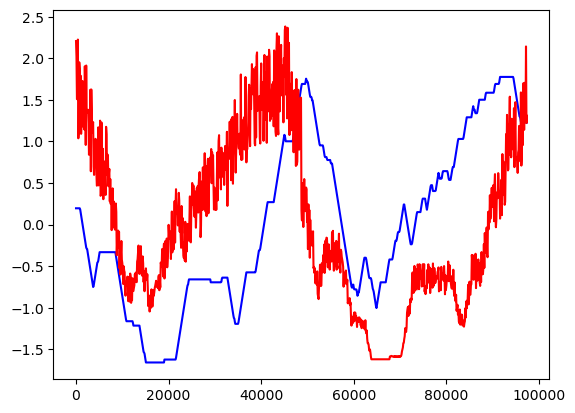

In [46]:
X_ran = randomize_stadial(df['X'].values, fraction=0.2)

# plot X_ran
fig, ax = plt.subplots()
plt.plot(df['Time'], zscore(df['X']), 'b-')
plt.plot(df['Time'], zscore(X_ran), 'r-')

   LibSize       X:Y       Y:X
0    100.0  0.813198  0.667264
1    200.0  0.865336  0.701560
2    300.0  0.895862  0.720145
3    400.0  0.914950  0.731940
4    500.0  0.925795  0.736770
5    600.0  0.932435  0.742239
6    700.0  0.936741  0.746615
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


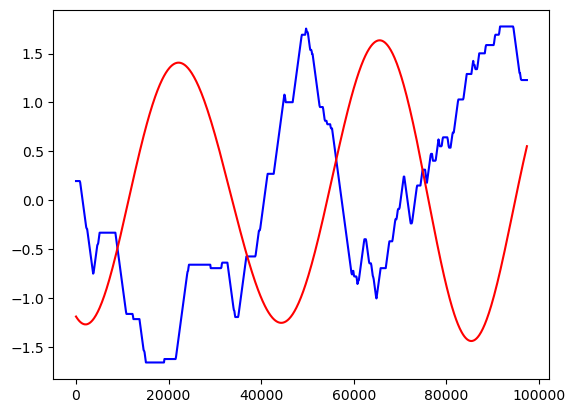

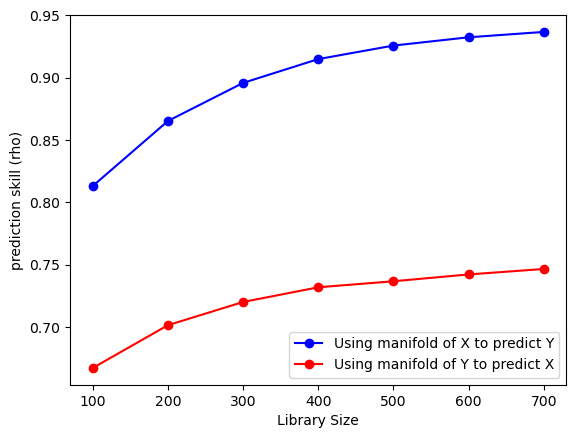

In [47]:
import pandas as pd
import numpy as np
from pyEDM import CCM
import matplotlib.pyplot as plt
from scipy.stats import zscore




df = pd.DataFrame({
    "Time": ages,
    "X": df_sd['percentage'],
    "Y":  df_obl["obl"]         # target to predict
})




# plot df
fig, ax = plt.subplots()
plt.plot(df['Time'], zscore(df['X']), 'b-')
plt.plot(df['Time'], zscore(df['Y']), 'r-')



# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 4,
    tau         = 10,
    columns     = "X",   # predictor
    target      = "Y",   # target
    libSizes    = "100 200 300 400 500 600 700",
    sample      = 100,
    random      = True,
    replacement = False,
    Tp          = 0
)

print(ccm_out)
print("Columns:", ccm_out.columns)

fig, ax = plt.subplots()
# plot the results
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-', label='Using manifold of X to predict Y')
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-', label='Using manifold of Y to predict X')
plt.xlabel("Library Size")
plt.ylabel('prediction skill (rho)')
plt.legend()
plt.show()

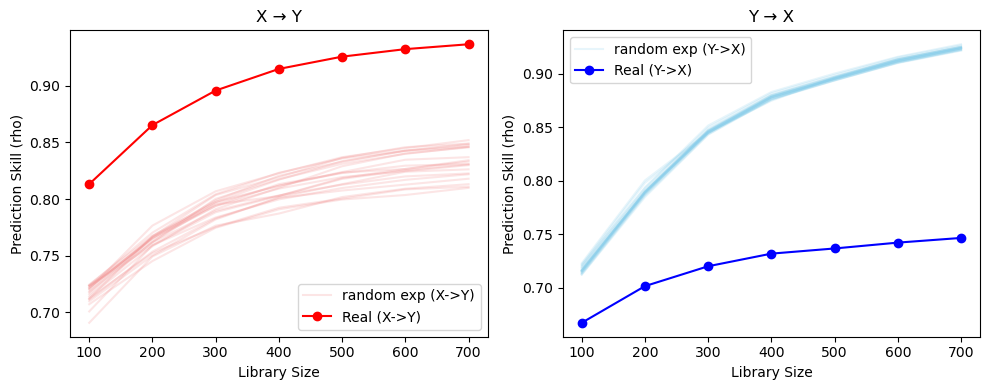

In [50]:
def randomize_stadial(stadial_data, fraction=0.1, seed=None):
    """
    1) Multiply original data by (1 + random variation in [-fraction, fraction]).
    2) Chop in half and rejoin (destroys original time ordering).
    """
    if seed is not None:
        np.random.seed(seed)
    
    N = len(stadial_data)
    # 1. Vary by ± fraction
    variation = 1.0 + fraction * (2*np.random.rand(N) - 1.0)  # e.g., ±10%
    randomized = stadial_data * variation
    
    # 2. Chop and rejoin
    half = N // 2
    randomized_swapped = np.concatenate([randomized[half:], randomized[:half]])
    
    return randomized_swapped


df = pd.DataFrame({
    "Time": ages,
    "X": df_sd['percentage'],
    "Y":  df_obl["obl"]         # target to predict
})


# Number of surrogate draws
n_ran = 20

# Storage for surrogates
ran_ccm_list_xy = []  # for X->Y direction


lib_sizes = "100 200 300 400 500 600 700"

for i in range(n_ran):
    # 1) Generate random surrogate stadial data
    X_ran = randomize_stadial(df['X'].values, fraction=0.1)
    
    # 2) Create DataFrame with the *same* Y (precession) but newly randomized X
    df_surr = pd.DataFrame({
        'Time': df['Time'],
        'X': X_ran,
        'Y': df['Y'].values
    })
    
    # 3) Run CCM for X->Y
    out_xy = CCM(
        dataFrame   = df_surr,
        E           = 4,
        tau         = 8,
        columns     = "X",
        target      = "Y",
        libSizes    = lib_sizes,
        sample      = 20,
        random      = True,
        replacement = False,
        Tp          = 0
    )
    ran_ccm_list_xy.append(out_xy)
    


import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# 1) X->Y subplot
for i, out_xy in enumerate(ran_ccm_list_xy):
    # Surrogate lines (fade them in background)
    label_xy = "random exp (X->Y)" if i == 0 else None
    ax1.plot(out_xy['LibSize'], out_xy['X:Y'], color='lightcoral', alpha=0.2, label=label_xy)

# Overlay the real data CCM
ax1.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'ro-', label='Real (X->Y)')
ax1.set_title("X → Y")
ax1.set_xlabel("Library Size")
ax1.set_ylabel("Prediction Skill (rho)")
ax1.legend()

# 2) Y->X subplot
for i, out_xy in enumerate(ran_ccm_list_xy):
    label_yx = "random exp (Y->X)" if i == 0 else None
    ax2.plot(out_xy['LibSize'], out_xy['Y:X'], color='skyblue', alpha=0.2, label=label_yx)

# Overlay the real data CCM
ax2.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'bo-', label='Real (Y->X)')
ax2.set_title("Y → X")
ax2.set_xlabel("Library Size")
ax2.set_ylabel("Prediction Skill (rho)")
ax2.legend()

plt.tight_layout()
plt.show()


